<a href="https://colab.research.google.com/github/zahariukpn-cs/discrete-math-lab1/blob/main/Lab1_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

# Task 1. Algorithm's analysis

In [24]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt
import time

### Generating graph

In [4]:

# You can use this function to generate a random graph with 'num_of_nodes'
# nodes and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi
    graph, but enforcing that the resulting graph is conneted
    (in case of undirected graphs)
    """


    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))

    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)

    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)

    if draw:
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue',
                    with_labels=True,
                    node_size=500,
                    arrowsize=20,
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)

        else:
            nx.draw(G, node_color='lightblue',
                with_labels=True,
                node_size=500)

    return G

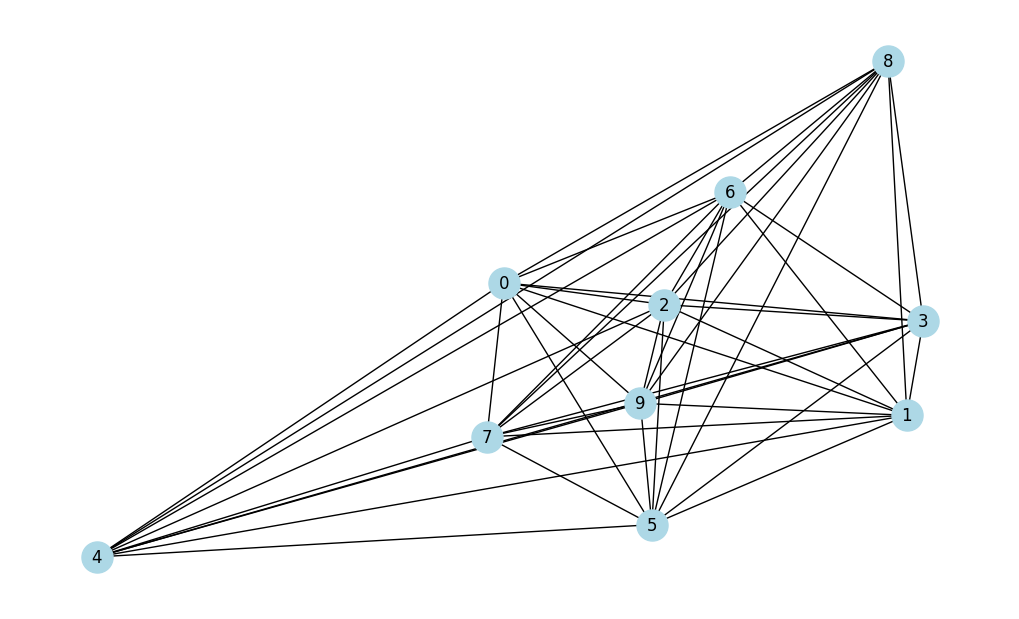

In [7]:
G = gnp_random_connected_graph(10, 1, False, True)

## Subtask 1.1 (1 point)

### Kruskal's algorithm

#### nx implementation

In [12]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

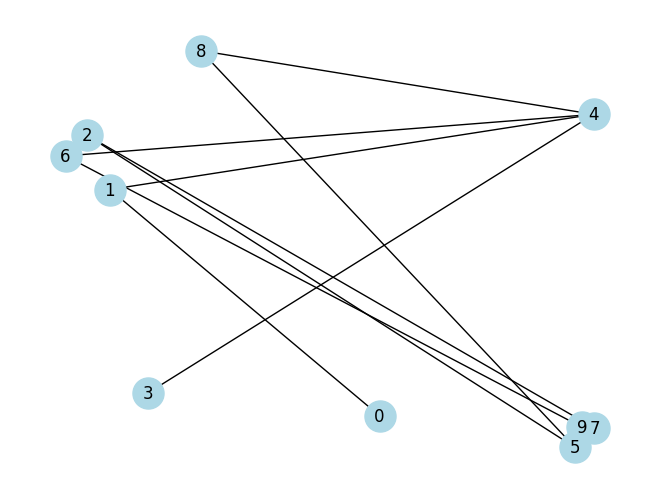

In [13]:
nx.draw(mstk, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [14]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 1), (1, 4), (2, 5), (2, 7), (3, 4), (4, 8), (4, 6), (5, 8), (6, 9)]),
 9)

#### Your implementation

In [15]:
def kruskal(graph):
    """
    Kruskal's algorithm for finding Minimum Spanning Tree (MST).

    The algorithm builds MST by selecting edges in order of increasing weight,
    adding each edge only if it doesn't create a cycle.

    Parameters:
        graph: NetworkX graph object (undirected)

    Returns:
        list: List of edges in MST as tuples (u, v, {'weight': w})

    Time Complexity: O(E log E) where E is number of edges

    Example:
        >>> G = gnp_random_connected_graph(5, 0.5)
        >>> mst = kruskal(G)
        >>> print(mst)
        [(0, 2, {'weight': -3}), (1, 3, {'weight': 2}), ...]
    """
    # дістаю всі ребра в форматі (0, 7, {'weight': -2}) і сортую по вазі, спочатку найлегші
    edges = sorted(graph.edges(data=True), key=lambda x: x[2]['weight'])

    # роблю словник вершин, щоб потім не брати двічі ребра, які з'єднують однакові вершини
    parent = {}
    for node in graph.nodes():
        parent[node] = node

    # одна вершина в словнику не мінятиме значення, якщо ми від якоїсь вершини
    # маємо не прямий шлях до іншої, то нема сенсу їх з'єднювати напряму, тобто якщо ми
    # маємо ребра між 1,2 і 2,3, то сенсу в ребрі 1,3 нема
    def find(parent, v):
        while parent[v] != v:
            v = parent[v]
        return v

    # тут просто перевіряємо чи є зв'язок між вершинами, якщо немає,
    # додаємо нове ребро до каркасу(щоб не було циклів)
    mst = []
    for a, b, e_weight in edges:
        if find(parent, a) != find(parent, b):
            mst.append((a, b, e_weight))
            parent[a] = b

    return mst

In [40]:
def get_min_execution_time(algo_func, graph, iterations=15):
    times = []
    for _ in range(iterations):
        start = time.time()
        algo_func(graph)
        times.append(time.time() - start)
    return min(times)

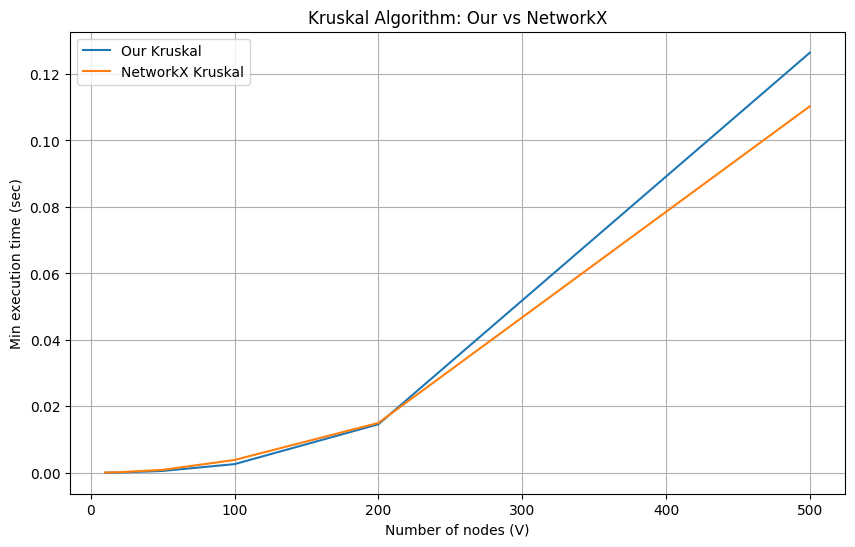

In [41]:
nodes_num = [10, 20, 50, 100, 200, 500]
our_result = []
nx_result = []

for n in nodes_num:
    G = gnp_random_connected_graph(n, 0.4)

    our = get_min_execution_time(kruskal, G)
    our_result.append(our)

    ntx = get_min_execution_time(lambda g: nx.minimum_spanning_tree(g, algorithm='kruskal'), G)
    nx_result.append(ntx)

plt.figure(figsize=(10, 6))
plt.plot(nodes_num, our_result, label='Our Kruskal')
plt.plot(nodes_num, nx_result, label='NetworkX Kruskal')
plt.title('Kruskal Algorithm: Our vs NetworkX')
plt.xlabel('Number of nodes (V)')
plt.ylabel('Min execution time (sec)')
plt.grid(True)
plt.legend()
plt.show()

Підсумок: Алгоритм Крускала працює зі складністю $O(E \log E)$ через сортування ребер. На графіку видно, що час зростає майже лінійно відносно кількості ребер.

#### Additional point (+0.5)

Use DSU (disjoint set union) in implementation of the algorithm

### Prim's algorithm

#### nx implementation

In [ ]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

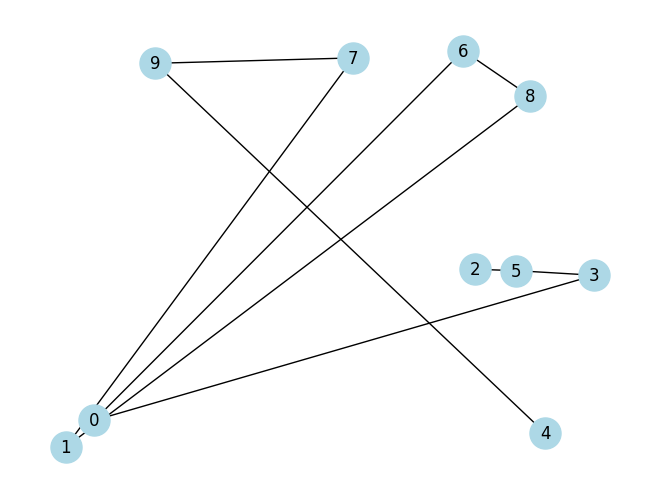

In [ ]:
nx.draw(mstp, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [ ]:
mstp.edges(), len(mstp.edges())

(EdgeView([(0, 6), (0, 3), (1, 8), (1, 7), (2, 5), (3, 5), (4, 9), (6, 8), (7, 9)]),
 9)

#### Your implementation

In [ ]:
# code here

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Subtask 1.2 (1 point)

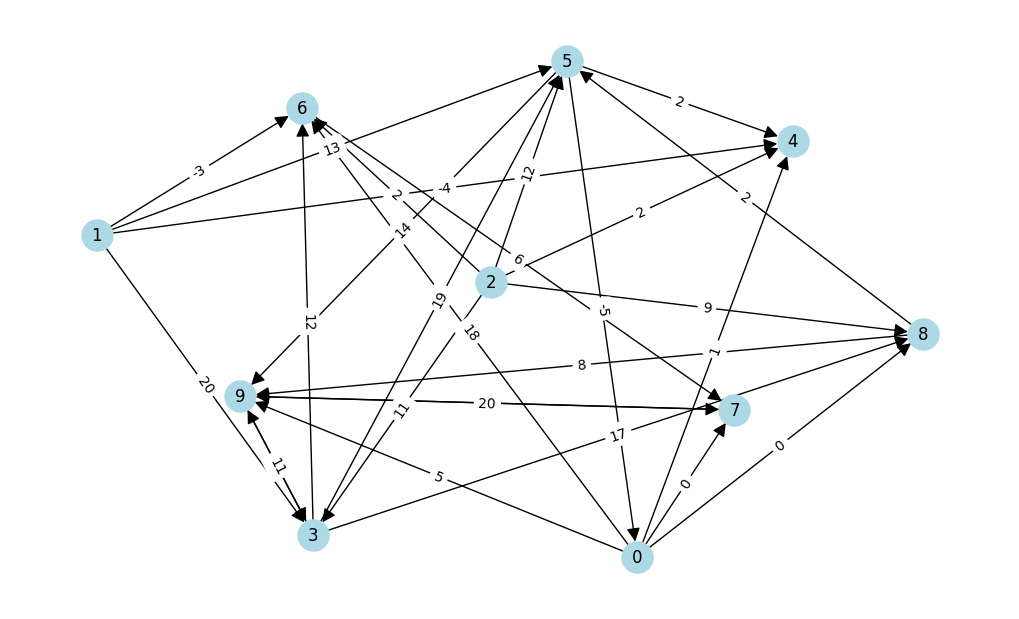

In [27]:
G = gnp_random_connected_graph(10, 0.5, True, True)

### Bellman-Ford algorithm

#### nx implementation

In [ ]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 1: 8
Distance to 9: 6
Distance to 6: 11
Distance to 7: 8
Distance to 8: 3
Distance to 5: 13


#### Your implementation

In [ ]:
# code here

### Floyd-Warshall algorithm

#### nx implementation

In [28]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G)
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

Distances with 0 source: {0: -3, 4: -2, 6: 14, 7: -3, 8: -3, 9: -9, 1: inf, 2: inf, 3: 2, 5: 2}
Distances with 1 source: {1: 0, 4: -4, 3: 10, 5: 10, 6: -3, 0: 5, 2: inf, 7: 3, 8: 5, 9: -1}
Distances with 2 source: {2: 0, 8: 4, 3: 9, 4: 2, 5: 9, 6: 2, 0: 4, 1: inf, 7: 4, 9: -2}
Distances with 3 source: {3: 0, 5: 16, 6: 12, 8: 11, 9: 5, 0: 11, 1: inf, 2: inf, 4: 12, 7: 11}
Distances with 4 source: {4: 0, 0: inf, 1: inf, 2: inf, 3: inf, 5: inf, 6: inf, 7: inf, 8: inf, 9: inf}
Distances with 5 source: {5: -3, 0: -8, 4: -7, 9: -14, 1: inf, 2: inf, 3: -3, 6: 9, 7: -8, 8: -8}
Distances with 6 source: {6: 0, 7: 6, 0: 22, 1: inf, 2: inf, 3: 14, 4: 23, 5: 27, 8: 22, 9: 3}
Distances with 7 source: {7: 0, 9: -3, 0: 16, 1: inf, 2: inf, 3: 8, 4: 17, 5: 21, 6: 20, 8: 16}
Distances with 8 source: {8: -6, 5: -1, 9: -12, 0: -6, 1: inf, 2: inf, 3: -1, 4: -5, 6: 11, 7: -6}
Distances with 9 source: {9: 0, 3: 11, 7: 19, 0: 19, 1: inf, 2: inf, 4: 20, 5: 24, 6: 23, 8: 19}


#### Your implementation

In [29]:
def floyd_warshall(graph):
    """
    Floyd-Warshall algorithm for finding shortest paths between all pairs of vertices.

    The algorithm works by iteratively improving path estimates by considering
    each vertex as a potential intermediate point in the path.

    Parameters:
        graph: NetworkX graph object (directed or undirected)

    Returns:
        tuple: (distance, prev)
            - distance: 2D list where distance[i][j] is shortest path from i to j
            - prev: 2D list where prev[i][j] stores intermediate vertex for path reconstruction

    Time Complexity: O(V^3) where V is number of vertices

    Note:
        - Works with negative edge weights
        - Can detect negative cycles (diagonal values become negative)

    Example:
        >>> G = gnp_random_connected_graph(5, 0.5, directed=True)
        >>> dist, prev = floyd_warshall(G)
        >>> print(dist[0][3])  # shortest distance from vertex 0 to 3
        7
    """
    nodes = graph.nodes()
    amount = len(nodes)
    edges = list(graph.edges(data=True))

    # матриця з вагою шляхів(список списків)
    distance = [[float('inf')] * amount for _ in range(amount)]

    # матриця міток
    prev = [[i + 1] * amount for i in range(amount)]

    # ставлю нулі по діагоналі
    def diagonal(matrix):
        for d in range(amount):
            matrix[d][d] = 0

    diagonal(distance)
    diagonal(prev)

    for a, b, e_weight in edges:
        distance[a][b] = e_weight['weight']
        prev[a][b] = a
        if not graph.is_directed():
            distance[b][a] = e_weight['weight']
            prev[b][a] = b

    # k це номер ітерації, i - номер рядка, j - стовпець
    for k in range(amount):
        for i in range(amount):
            for j in range(amount):
                if distance[i][k] + distance[k][j] < distance[i][j]:
                    distance[i][j] = distance[i][k] + distance[k][j]
                    prev[i][j] = prev[k][j]

    return distance, prev


Вершин: 10 — завершено. (Наш: 0.0002с, NX: 0.0003с)
Вершин: 30 — завершено. (Наш: 0.0029с, NX: 0.0045с)
Вершин: 50 — завершено. (Наш: 0.0142с, NX: 0.0254с)
Вершин: 80 — завершено. (Наш: 0.0635с, NX: 0.0861с)
Вершин: 100 — завершено. (Наш: 0.1292с, NX: 0.1926с)


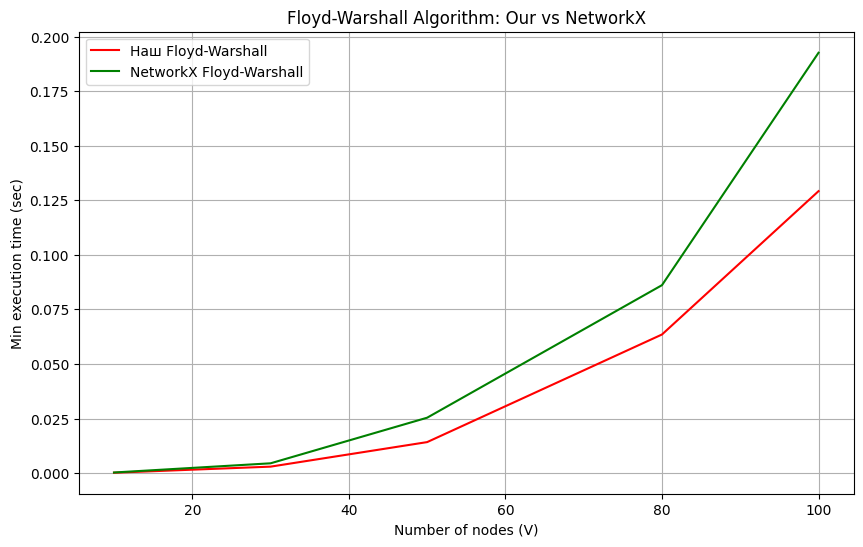

In [37]:
fw_nodes_num = [10, 30, 50, 80, 100]
fw_our_result = []
fw_nx_result = []

for n in fw_nodes_num:
    #directed=True
    G = gnp_random_connected_graph(n, 0.4, directed=True)

    t_our = get_min_execution_time(floyd_warshall, G, iterations=5)
    fw_our_result.append(t_our)

    t_nx = get_min_execution_time(nx.floyd_warshall_predecessor_and_distance, G, iterations=5)
    fw_nx_result.append(t_nx)

    print(f"Вершин: {n} — завершено. (Наш: {t_our:.4f}с, NX: {t_nx:.4f}с)")

plt.figure(figsize=(10, 6))
plt.plot(fw_nodes_num, fw_our_result, label='Наш Floyd-Warshall', color='red')
plt.plot(fw_nodes_num, fw_nx_result, label='NetworkX Floyd-Warshall', color='green')
plt.title('Floyd-Warshall Algorithm: Our vs NetworkX')
plt.xlabel('Number of nodes (V)')
plt.ylabel('Min execution time (sec)')
plt.grid(True)
plt.legend()
plt.show()

Підсумок: Чітко спостерігається кубічна залежність $O(V^3)$. При переході від 50 до 100 вершин час зростає приблизно у 7 разів.

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Useful explanations

### How to get list of edges for your algorithm


In [ ]:
edges = list(G.edges()) # by default G.edges are EdgesView class

In [ ]:
edges[:5]

[(0, 1), (0, 9), (1, 6), (1, 7), (1, 8)]

### To get edges with weights

In [ ]:
edges = list(G.edges(data=True))

In [ ]:
edges[:5]

[(0, 1, {'weight': 8}),
 (0, 9, {'weight': 6}),
 (1, 6, {'weight': 3}),
 (1, 7, {'weight': 8}),
 (1, 8, {'weight': 8})]

In [ ]:
nodes = list(G.nodes())
print(nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### Example on time measuring

Read more on this: https://realpython.com/python-timer/

Recall that you should measure times for 5, 10, 20, 50, 100, 200, 500 nodes 1000 times (and take mean of time taken for each node amount).

Then you should build the plot for two algorithms (x - data size, y - mean time of execution).

In [ ]:
import time
from tqdm import tqdm

In [ ]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):

    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.4, False)

    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()

    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 396.21it/s]


0.0007538454532623291

# Task 2. Decision Tree Classifier

In [ ]:
# scikit-learn package
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## General idea


You are expected to write a quite simple, yet good core logic of decision tree classifier class. Additionaly, you need to test your results and write down a report on what you've done, which principles used and explain the general process.

Hopefully, you have already learned what is decision tree classifier and how it work. For better understanding, and in case if something is still unclear for you, here are some useful links on basics of DTC:
- https://www.youtube.com/watch?v=ZVR2Way4nwQ
- https://towardsdatascience.com/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
- https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial
- https://medium.com/data-science/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575

Also, for those interested to learn more about machine learning and particulary Desicion Trees - here is a great course on Coursera (you may be interested in the whole course or just this particular week):
- https://www.coursera.org/learn/advanced-learning-algorithms/home/week/4

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Dataset

You can use Iris dataset for this task. It is a very popular dataset for machine learning and data science. It contains 150 samples of 3 different species of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.
Read more on this: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
https://en.wikipedia.org/wiki/Iris_flower_data_set

However, using more interesting and intricate datasets is much appreciated. You can use any dataset you want, but it should be a classification one. For example you can use breast cancer or wine datasets, which are also available in sklearn.datasets. Or you can use any other dataset you find interesting.

P.S. In case you are not sure if your dataset is suitable, feel free to ask assistants :).

In [ ]:
# Load dataset
iris = load_iris()
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [ ]:
iris.data.shape

(150, 4)

This means that we have 150 entries (samples, infos about a flower). The columns being: Sepal Length, Sepal Width, Petal Length and Petal Width(features). Let's look at first two entries:

In [ ]:
iris.data[0:2]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2]])

### To undestand data little bit better, let's plot some features

Text(0, 0.5, 'Sepal width')

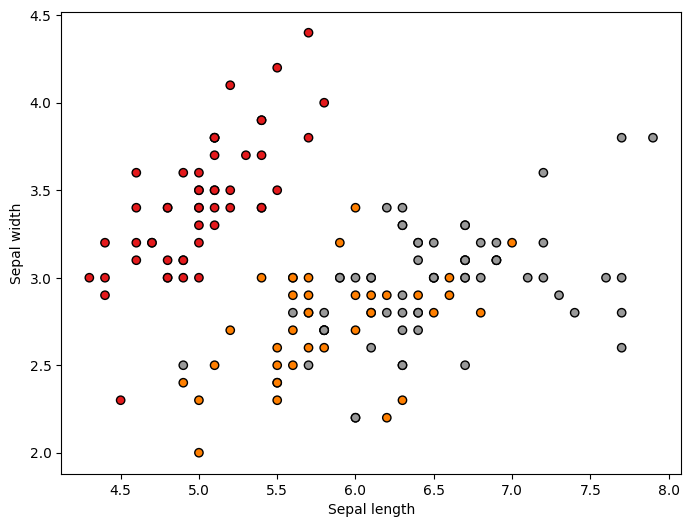

In [ ]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

From this we can clearly see, that even basing on those two parameters, we can clearly divide (classify) out data into several groups. For this, we will use decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#tree


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Example of usage

**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [ ]:
clf = DecisionTreeClassifier()

X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
X_test.shape, y_test.shape

((30, 4), (30,))

### Model learning

It learns its parameters (where it should split data and for what threshold value) basing on the training dataset. It is done by minimizing some cost function (e.g. Gini impurity or entropy).

In [ ]:
clf = clf.fit(X, y)

### Visualization of produced tree

You do not need to understand this piece of code :)

In [ ]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("iris")

'iris.pdf'

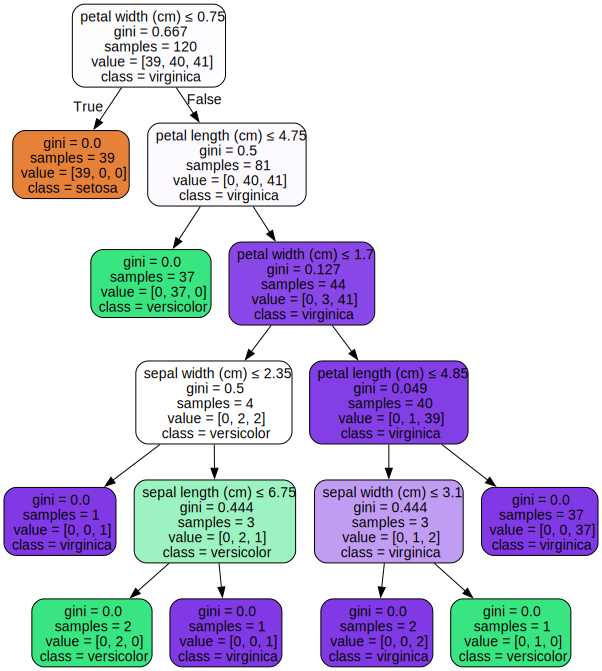

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,
                     feature_names=iris.feature_names,
                     class_names=iris.target_names,
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Prediction step

Now we can use our model to predict which type has a flower, basing on its parameters.

This is conducted basically via traversing the tree that you can see above.

In [ ]:
predictions = clf.predict(X_test)

### We can also measure the accuracy of our model

In [ ]:
sum(predictions == y_test) / len(y_test)

np.float64(0.8)

To get clearer intuition about predicion, let's look at those X, that should be labeled to some flower

In [ ]:
y_test

array([2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 1, 2, 1, 1, 1, 0, 2, 1, 0, 1, 0, 0,
       1, 2, 1, 0, 1, 1, 0, 2])


Here you can traverse the tree above by yourself and make sure that prediction works

In [ ]:
X_test[1]

array([4.9, 3.1, 1.5, 0.2])

In [ ]:
clf.predict([X_test[1]])

array([0])

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Decision tree classifier (2 point)

###  Gini impurity


Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$


### Your implementation

> We recommend using additional functions in `DecisionTreeClassifier` class, to make the implementation process easier.

In [42]:

class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.X = X
        self.y = y
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

In [43]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int) -> None:
        self.max_depth = max_depth
        self.tree = None
        self.number_of_classes = None

    def gini(self, y: np.ndarray) -> float:
        if len(y) == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        return 1 - np.sum(probs ** 2)

    def best_split(self, X: np.ndarray, y: np.ndarray):
        best_gini = float('inf')
        best_feature = None
        best_threshold = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue

                gini = (np.sum(left_mask) * self.gini(y[left_mask]) +
                        np.sum(right_mask) * self.gini(y[right_mask])) / len(y)

                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def build_tree(self, X: np.ndarray, y: np.ndarray, depth: int) -> Node:
        node = Node(X, y)

        if depth >= self.max_depth or len(np.unique(y)) == 1 or len(y) < 2:
            return node

        feature, threshold = self.best_split(X, y)

        if feature is None:
            return node

        node.feature_index = feature
        node.threshold = threshold

        left_mask = X[:, feature] <= threshold
        node.left = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        node.right = self.build_tree(X[~left_mask], y[~left_mask], depth + 1)

        return node

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self.number_of_classes = np.unique(y).size
        self.tree = self.build_tree(X, y, depth=0)

    def predict_one(self, node: Node, x: np.ndarray) -> int:
        if node.left is None and node.right is None:
            values, counts = np.unique(node.y, return_counts=True)
            return values[np.argmax(counts)]

        if x[node.feature_index] <= node.threshold:
            return self.predict_one(node.left, x)
        else:
            return self.predict_one(node.right, x)

    def predict(self, X_test: np.ndarray) -> list:
        return [self.predict_one(self.tree, x) for x in X_test]

In [44]:

def evaluate(X_test: list[list], y_test: list) -> float:
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)
    """
    y_pred = clf.predict(X_test)
    return np.mean(np.array(y_pred) == np.array(y_test))

#### Additional point (+0.5)

Use Laplace smoothing, explain what is the point of using it